In [16]:
import pandas as pd
import requests
import geopy
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import osmnx as ox
import networkx as nx

Data Exploration

In [17]:
df = pd.read_csv(r"C:\Users\viven\Downloads\Food_Delivery\Food_Delivery_Dataset.csv")

In [18]:
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30
...,...,...,...,...,...,...,...,...,...,...,...
45588,7C09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,Meal,motorcycle,32
45589,D641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,Buffet,motorcycle,36
45590,4F8D,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,Drinks,scooter,16
45591,5EEE,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,Snack,motorcycle,26


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Time_taken(min)              45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB


Data Segmentation

In [20]:
indore_df = df[df['Delivery_person_ID'].str.contains("INDORE", na=False, case=False)].copy()
print(indore_df.shape)

indore_df.describe()

(3159, 11)


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min)
count,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000
mean,29.610953,4.631466,22.491861,75.551831,22.799162,75.950793,26.116176
std,5.745799,0.324038,3.327106,7.137813,0.044333,0.037317,9.390824
min,15.000000,1.000000,-22.761593,-75.902847,22.661847,75.876059,10.000000
25%,25.000000,4.600000,22.725835,75.884167,22.770072,75.921991,19.000000
50%,29.000000,4.700000,22.745049,75.887648,22.800040,75.947522,25.000000
75%,35.000000,4.800000,22.751857,75.893400,22.831230,75.976699,32.000000
max,50.000000,6.000000,22.761593,75.903365,22.891593,76.033365,54.000000


In [21]:
from geopy.distance import geodesic

# Indore city's location
city_lat = 22.719568
city_lon = 75.857727

# Define the distance threshold (in meters)
distance_threshold = 15  # Adjust this as needed, it's in kilometers

# Function to calculate the distance from the city center
def calculate_distance(lat, lon, city_lat, city_lon):
    return geodesic((lat, lon), (city_lat, city_lon)).kilometers

# Calculate the distance for restaurant and delivery locations
indore_df['Restaurant_distance'] = indore_df.apply(lambda row: calculate_distance(row['Restaurant_latitude'], row['Restaurant_longitude'], city_lat, city_lon), axis=1)
indore_df['Delivery_distance'] = indore_df.apply(lambda row: calculate_distance(row['Delivery_location_latitude'], row['Delivery_location_longitude'], city_lat, city_lon), axis=1)

# Drop rows that are beyond the distance threshold for both restaurant and delivery locations
indore_df_filtered = indore_df[(indore_df['Restaurant_distance'] <= distance_threshold) & (indore_df['Delivery_distance'] <= distance_threshold)]

# Drop the distance columns
indore_df_filtered = indore_df_filtered.drop(columns=['Restaurant_distance', 'Delivery_distance'])

In [22]:
indore_df_filtered

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
93,6D19,INDORES12DEL02,38,4.9,22.748060,75.893400,22.768060,75.913400,Drinks,scooter,15
104,6757,INDORES05DEL02,24,4.3,22.727021,75.884167,22.747021,75.904167,Meal,motorcycle,19
133,977D,INDORES19DEL02,27,4.7,22.745536,75.893106,22.765536,75.913106,Buffet,motorcycle,14
163,3A5A,INDORES08DEL02,24,4.9,22.725748,75.898497,22.775748,75.948497,Snack,scooter,22
...,...,...,...,...,...,...,...,...,...,...,...
45483,120B,INDORES02DEL02,25,4.0,22.651847,75.881991,22.671847,75.901991,Snack,motorcycle,19
45502,60D5,INDORES16DEL02,33,4.8,22.744648,75.894377,22.794648,75.944377,Buffet,scooter,16
45518,863,INDORES05DEL01,29,4.6,22.727021,75.884167,22.737021,75.894167,Snack,electric_scooter,25
45550,7483,INDORES04DEL01,23,4.6,22.753659,75.903365,22.763659,75.913365,Snack,scooter,12


Feature Engineering

In [23]:
df1 = indore_df_filtered.copy()

# Define a function to calculate the shortest path distance
def calculate_shortest_path_distance(row, G):
    restaurant_lat_lon = (row['Restaurant_latitude'], row['Restaurant_longitude'])
    delivery_lat_lon = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
    
    # Get the nearest nodes to the restaurant and delivery locations
    orig_node = ox.distance.nearest_nodes(G, row['Restaurant_longitude'], row['Restaurant_latitude'])
    dest_node = ox.distance.nearest_nodes(G, row['Delivery_location_longitude'], row['Delivery_location_latitude'])
    
    # Calculate the shortest path distance between the nodes
    shortest_path_distance = nx.shortest_path_length(G, orig_node, dest_node, weight='length')
    
    return shortest_path_distance

# Create a graph from OpenStreetMap data
G = ox.graph_from_point((22.719568, 75.857727), dist=10000, network_type='drive')

# Apply the function to each row in the dataset
df1['Driving_distance'] = df1.apply(lambda row: calculate_shortest_path_distance(row, G), axis=1)

In [24]:
df1

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),Driving_distance
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3967.774166
93,6D19,INDORES12DEL02,38,4.9,22.748060,75.893400,22.768060,75.913400,Drinks,scooter,15,4742.651782
104,6757,INDORES05DEL02,24,4.3,22.727021,75.884167,22.747021,75.904167,Meal,motorcycle,19,3674.590510
133,977D,INDORES19DEL02,27,4.7,22.745536,75.893106,22.765536,75.913106,Buffet,motorcycle,14,4144.178413
163,3A5A,INDORES08DEL02,24,4.9,22.725748,75.898497,22.775748,75.948497,Snack,scooter,22,9048.252129
...,...,...,...,...,...,...,...,...,...,...,...,...
45483,120B,INDORES02DEL02,25,4.0,22.651847,75.881991,22.671847,75.901991,Snack,motorcycle,19,5196.644558
45502,60D5,INDORES16DEL02,33,4.8,22.744648,75.894377,22.794648,75.944377,Buffet,scooter,16,10841.732137
45518,863,INDORES05DEL01,29,4.6,22.727021,75.884167,22.737021,75.894167,Snack,electric_scooter,25,2019.953271
45550,7483,INDORES04DEL01,23,4.6,22.753659,75.903365,22.763659,75.913365,Snack,scooter,12,1871.635026


In [25]:
new_df = df1[['Delivery_person_Age', 'Delivery_person_Ratings', 'Type_of_vehicle', 'Time_taken(min)', 'Driving_distance']]
new_df

,Delivery_person_Age,Delivery_person_Ratings,Type_of_vehicle,Time_taken(min),Driving_distance
0,37,4.9,motorcycle,24,3967.774166
93,38,4.9,scooter,15,4742.651782
104,24,4.3,motorcycle,19,3674.590510
133,27,4.7,motorcycle,14,4144.178413
163,24,4.9,scooter,22,9048.252129
...,...,...,...,...,...
45483,25,4.0,motorcycle,19,5196.644558
45502,33,4.8,scooter,16,10841.732137
45518,29,4.6,electric_scooter,25,2019.953271
45550,23,4.6,scooter,12,1871.635026


In [26]:
new_df['Type_of_vehicle'].unique()

array(['motorcycle ', 'scooter ', 'electric_scooter ', 'bicycle '],
      dtype=object)

In [28]:
new_df['Driving_distance'] = new_df['Driving_distance'] / 1000

new_df = pd.get_dummies(new_df, columns=['Type_of_vehicle'])

C:\Users\viven\AppData\Local\Temp\ipykernel_14008\1071392286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Driving_distance'] = new_df['Driving_distance'] / 1000


In [29]:
new_df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Time_taken(min)',
       'Driving_distance', 'Type_of_vehicle_bicycle ',
       'Type_of_vehicle_electric_scooter ', 'Type_of_vehicle_motorcycle ',
       'Type_of_vehicle_scooter '],
      dtype='object')

Linear regression model: Target variable (Time taken (min))

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

new_df.columns = new_df.columns.str.strip()

X = new_df[['Delivery_person_Age', 'Driving_distance', 'Type_of_vehicle_bicycle', 'Type_of_vehicle_electric_scooter', 'Type_of_vehicle_motorcycle', 'Type_of_vehicle_scooter']]
y = new_df['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

coefficients = pd.DataFrame(model1.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Root Mean Squared Error: 7.675437993615256
                                  Coefficient
Delivery_person_Age                  0.422511
Driving_distance                     0.613230
Type_of_vehicle_bicycle              7.127994
Type_of_vehicle_electric_scooter    -4.102801
Type_of_vehicle_motorcycle           0.291377
Type_of_vehicle_scooter             -3.316571


Coefficient Interpretations:

Delivery_person_Age (0.42): For each additional year in the delivery person's age, the predicted delivery time increases by approximately 0.40 minutes.

Driving_distance (0.61): For each additional kilometer of driving distance, the predicted delivery time increases by approximately 0.61 minutes.

Type_of_vehicle_bicycle (7.12): If the delivery is made using a bicycle (compared to other vehicles), the predicted delivery time increases by approximately 2.27 minutes.

Type_of_vehicle_electric_scooter (-4.10): If the delivery is made using an electric scooter, the predicted delivery time decreases by approximately -4.10 minutes.

Type_of_vehicle_motorcycle (0.29): If the delivery is made using a motorcycle, the predicted delivery time increases by approximately 0.3 minutes.

Type_of_vehicle_scooter (-3.31): If the delivery is made using a scooter, the predicted delivery time decreases by approximately 3.30 minutes.

In summary:

Older delivery personnel and longer driving distances increase delivery time.

Bicycles and motorcycles increase delivery time compared to other vehicles.

Electric scooters and scooters decrease delivery time compared to other vehicles.

RMSE (Root Mean Squared Error) of 7.67 means that, on average, the predictions made by our model are off by approximately 7.67 minutes from the actual values.

Matplotlib is building the font cache; this may take a moment.


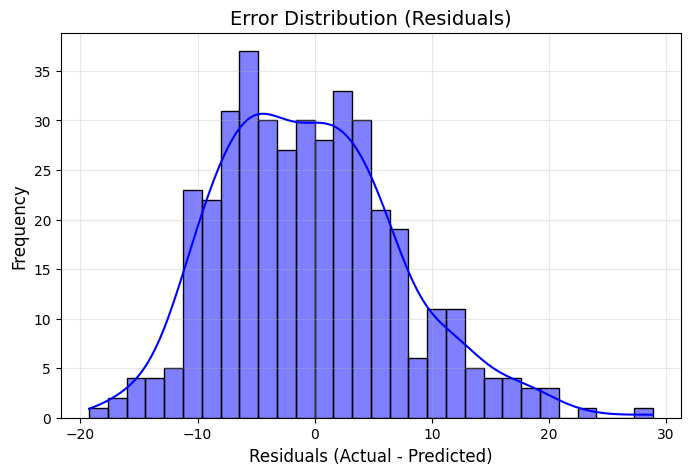

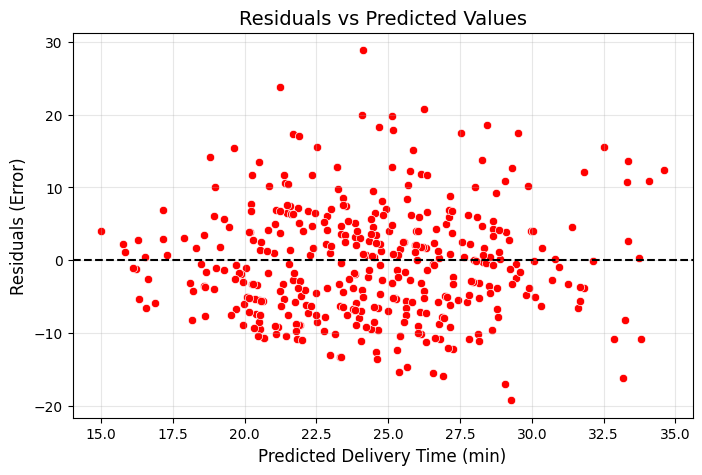

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot the residuals' distribution (Histogram)
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title('Error Distribution (Residuals)', fontsize=14)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot residuals vs predicted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
plt.title('Residuals vs Predicted Values', fontsize=14)
plt.xlabel('Predicted Delivery Time (min)', fontsize=12)
plt.ylabel('Residuals (Error)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Interpretation: The residuals are centered around 0 with a roughly normal distribution, it indicates that the model has good predictive behavior. The scatterplot shows a random spread with no clear patterns, it suggests that the model captures the data well without systematic bias.

Linear regression: Target variable (Delivery person rating)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

new_df.columns = new_df.columns.str.strip()

X2 = new_df[['Delivery_person_Age', 'Time_taken(min)', 'Driving_distance', 'Type_of_vehicle_bicycle', 'Type_of_vehicle_electric_scooter', 'Type_of_vehicle_motorcycle', 'Type_of_vehicle_scooter']]
y2 = new_df['Delivery_person_Ratings']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

y2_pred = model2.predict(X2_test)

rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))
print(f'Root Mean Squared Error: {rmse}')

coefficients = pd.DataFrame(model2.coef_, X2.columns, columns=['Coefficient'])
print(coefficients)

Root Mean Squared Error: 0.31881096551089155
                                  Coefficient
Delivery_person_Age                  0.002691
Time_taken(min)                     -0.012242
Driving_distance                     0.004152
Type_of_vehicle_bicycle             -2.694276
Type_of_vehicle_electric_scooter     0.918802
Type_of_vehicle_motorcycle           0.880615
Type_of_vehicle_scooter              0.894859


Coefficient Interpretations:

Time_taken(min) (-0.012): For each additional minute taken, the predicted rating decreases by approximately 0.012 units. This implies that longer delivery times might lead to lower ratings.

Driving_distance (0.004): For each additional kilometer in driving distance, the predicted rating increases by approximately 0.004 units. This suggests that longer driving distances might be slightly associated with higher ratings.

Type_of_vehicle_bicycle (-2.69): If the delivery is made using a bicycle, the predicted rating decreases by approximately 2.69 units compared to other vehicle types.

Type_of_vehicle_electric_scooter (0.91): If the delivery is made using an electric scooter, the predicted rating increases by approximately 0.91 units compared to other vehicle types.

Type_of_vehicle_motorcycle (0.88): If the delivery is made using a motorcycle, the predicted rating increases by approximately 0.88 units compared to other vehicle types.

Type_of_vehicle_scooter (0.89): If the delivery is made using a scooter, the predicted rating increases by approximately 0.036 units compared to other vehicle types.

In conclusion:

Older delivery personnel receive slightly higher ratings.

Longer delivery times negatively impact ratings.

Longer driving distances slightly improve ratings.

Bicycles and motorcycles slightly decrease ratings compared to other vehicles.

Electric scooters and scooters slightly improve ratings compared to other vehicles.

The average error in predictions is approximately 0.31 units. Given that rating scales are (1,5) an RMSE of 0.31 suggests that model is quite accurate.

In [ ]:
with open('model1.pkl','wb') as file:
    pickle.dump(model1, file)
    
with open('model2.pkl','wb') as file:
    pickle.dump(model2, file)